In [1]:
# importing all the libraries
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report,confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ranji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Fetching the Manually segregated Dataset


In [2]:
df_add = pd.read_csv("C:/Users/ranji/Desktop/SE/Project/Manual analysis/added.csv")
df_format = pd.read_csv("C:/Users/ranji/Desktop/SE/Project/Manual analysis/Format errors.csv")
df_grammer = pd.read_csv("C:/Users/ranji/Desktop/SE/Project/Manual analysis/grammer.csv")
df_spam = pd.read_csv("C:/Users/ranji/Desktop/SE/Project/Manual analysis/spam.csv")
df_typo = pd.read_csv("C:/Users/ranji/Desktop/SE/Project/Manual analysis/typo errors.csv")


In [3]:
df_dataset = pd.concat([df_add, df_format, df_grammer, df_spam, df_typo], axis=0)

In [4]:
df_dataset = df_dataset.drop(["Unnamed: 0"], axis=1)


In [7]:
df_dataset

,data,label
355,<sub>*Additional details to the [previous answ...,grammatic errors
66,If you want to insert ellipsis dependent on th...,spam
1242,I get the following error when I do a simple c...,added or removed
1228,The function `dfidx()` is build for data frame...,added or removed
1218,I believe the best way to go is to have an inp...,added or removed
...,...,...
604,<h2>Analysis of Problem</h2>\r\n\r\nThe issue ...,added or removed
116,I want to find empty area in an image (its x-y...,typo errors
362,"if [[ ""$0"" = /* ]]\r\n then\r\n :...",typo errors
11,In my `jsp` page I have a text box which conta...,typo errors


In [6]:
# shuffling the dataset
df_dataset = shuffle(df_dataset)

## Dataset class-wise count before resampling

In [8]:
df_dataset["label"].value_counts()

added or removed    1285
grammatic errors     460
typo errors          435
Format errors        224
spam                 112
Name: label, dtype: int64

In [9]:
df_Filtered_data = df_dataset["data"]
df_Filtered_label =  df_dataset["label"]
df_X = list(df_Filtered_data.copy())
df_y = list(df_Filtered_label.copy())

## Data Pre-processing 

In [13]:
# since removal of contractions and lemmatization reduced the performance of the model, they were not included
def text_preprocess(ds):
    for m in tqdm(ds):

        result = []
        # Retain only alphabets
        #main_words = re.sub('[^a-zA-Z]', ' ', str(ds[m]))
        main_words = m        
    
        
        #remove contractions "don't -> do not"
        #main_words = [contractions.fix(w) for w in main_words if len(w) > 1]
        
        # Remove stopwords
        main_words = [w for w in main_words if not w in set(stopwords.words('english'))]  
         
        # Group different forms of the same word
        #lem = WordNetLemmatizer()
        #main_words = [lem.lemmatize(w) for w in main_words if len(w) > 1]     
        
        #adding the questions length as an additional feature

       
        main_words = ' '.join(main_words)
        result.append(main_words)
        #ds[m] = main_words

    return result

In [11]:
df_X[1850]

'A Java application can be packaged in various ways. Please go through [Java Packaging Overview](https://docs.oracle.com/javase/8/docs/technotes/guides/deploy/packaging.html#BABCIBAD) to find everything about it. One of the packaging is a `self-contained Java application`.\r\n\r\nThere are different ways to create these packages :\r\n\r\n- Use the `javapackager` tools that comes with your JDK\r\n- JavaFX Ant Tasks\r\n- JavaFX Maven Plugin for a maven project\r\n\r\n\r\nSelf-contained application is one the ways how your application can be packaged and is platform specific. The bundle contains :\r\n\r\n - The application package\r\n - A private copy of the JRE\r\n\r\nA list of available bundles can be [found here](https://docs.oracle.com/javase/8/docs/technotes/guides/deploy/self-contained-packaging.html#A1324980).\r\n\r\nLet us check out the various tools available at our disposal and how to use them:\r\n\r\n**JavaPackager Tool**\r\n\r\n[JavaPackager Tool](https://docs.oracle.com/javas

In [14]:
pre_processedData = text_preprocess(df_X)

<ipython-input-13-9e1012c2ccec>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm(ds):


In [19]:
pre_processedData

["C l l n g   P h n   c   e h   u n g   h e   c l   n e     r e   c n ,   b u   c n   b e     r e l   e e   r e   f r   l n g   c l   n e .   S e e   I   u e   ` e l f `   w h n   h e   e   c l     c l l   h e   c   e h ,   b e c u e   I   f n     l k   c l e n e r . \r \n \r \n ` ` ` p h n \r \n c l   A S e w h L n g B u D e c r p v e C l N e : \r \n \r \n       e f   _ _ n _ _ ( e l f ) : \r \n             #   T h   w r k ,   b u   '   n   e e r e \r \n             A S e w h L n g B u D e c r p v e C l N e . _ e h n g _ c ( ) \r \n \r \n             #   T h   w r k     n   l k   c l e n e r . \r \n             e l f . _ e h n g _ c ( ) \r \n \r \n       @ c e h \r \n       e f   _ e h n g _ c ( ) : \r \n             p r n ( ' S c   e h   c l l e . ' ) \r \n ` ` ` \r \n \r \n M   u n e r n n g     h   c l l n g     c   e h   w h   ` e l f `   g e   n e r p r e e     ` C l N e . c _ e h ( e l f ) ` ,   w h e r e   ` e l f `   w u l   b e   g n r e   b   h e   c   e h . < b r > \r \n * 

In [56]:
list(df_Filtered_data)[1]

'\r\n\r\n\r\n\r\n**Problem statemet**- i want to create function for last_Week_volume and this_week_volume and pass it column. can u sugest dynamic query.??\r\nso that through it will be possible to me calculate day wise last week volume and this week volume  for old two year data '

In [15]:
df_X[1]

'If you want to insert ellipsis dependent on the width of the string rather then the count of characters, then use this code:\r\n\r\n    public static String DoPathEllipsis(String s_Path, Font i_Font, int s32_Width)\r\n    {\r\n        TextFormatFlags e_Flags = TextFormatFlags.PathEllipsis | TextFormatFlags.ModifyString;\r\n        TextRenderer.MeasureText(s_Path, i_Font, new Size(s32_Width, 100), e_Flags);\r\n\r\n        int Nul = s_Path.IndexOf((Char)0);\r\n        if (Nul > 0)\r\n            s_Path = s_Path.Substring(0, Nul);\r\n        return s_Path;\r\n    }\r\n\r\nTextFormatFlags.ModifyString shortens the path and inserts a \'\\0\' character into the string. It is unusual in C# that a string is modified. The reason is that the underlying Windows API `DrawTextW()` works like this.\r\nBut the modified string will always be shorter than the input string, so there is no problem: A buffer overflow is not possible.\r\n\r\nExample:\r\n\r\n    String s_Text = @"C:\\WINDOWS\\Installer{40B

In [73]:
#Extracting the bag of words for vectorization
bag_of_words = []
for i in tqdm(df_X):
    lis = i.split()
    for j in lis:
        if j not in bag_of_words:
            bag_of_words.append(j)

<ipython-input-73-6de72bd43ab8>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(df_X):


In [74]:
# Building a TF IDF matrix out of the bag of words

td = TfidfVectorizer()
Vectorized_X = td.fit(bag_of_words)


In [78]:
# Resampling the data and getting train and test sets 
from imblearn.over_sampling import RandomOverSampler

# Vectorize the input data
Questions_Vectorized= Vectorized_X.transform(df_X)

# Only the minority classes are resampled
resample_data = RandomOverSampler(sampling_strategy='not majority', random_state=5)

# The data is fit into the seleted resampler
X_resampled, y_resampled = resample_data.fit_resample(Questions_Vectorized, df_y)
# The resampled data is split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, y_resampled, test_size=0.2,random_state=20)

## Dataset class-wise count after resampling

In [79]:
resample_label_train = pd.DataFrame()
resample_label_train["label"] = Y_train

In [80]:
resample_label_train.value_counts()

label           
spam                1035
typo errors         1034
grammatic errors    1029
Format errors       1024
added or removed    1018
dtype: int64

# Training and evaluating the LogisticRegression classifier


 Modle's Accuracy:  85.91 %

Classification Report

                   precision    recall  f1-score   support

   Format errors       0.89      0.96      0.92       261
added or removed       0.84      0.67      0.74       267
grammatic errors       0.85      0.80      0.83       256
            spam       0.94      1.00      0.97       250
     typo errors       0.78      0.87      0.82       251

        accuracy                           0.86      1285
       macro avg       0.86      0.86      0.86      1285
    weighted avg       0.86      0.86      0.86      1285


Confusion Matrix


<AxesSubplot:>

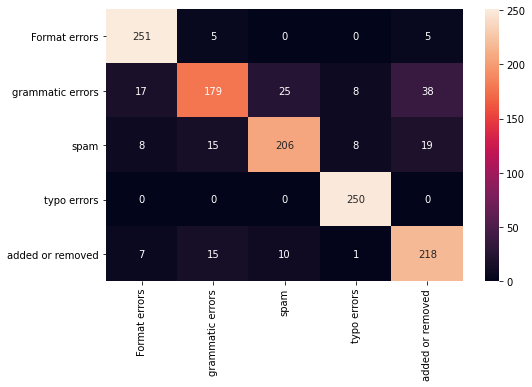

In [99]:
# Logistic regression for classifier
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier.fit(X_train, Y_train)


# Classification metrics
y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report
classification_report = classification_report(Y_test, y_pred)

print("\n Modle's Accuracy: ", (round((accuracy_score(Y_test, y_pred))*100,2)),"%")
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)


cm = confusion_matrix(Y_test,y_pred)


df_cm = pd.DataFrame(cm, index = [i for i in list(set(Y_train))],
                  columns = [i for i in list(set(Y_train))])
plt.figure(figsize = (8,5))
print('\nConfusion Matrix')
print('======================================================')
sn.heatmap(df_cm, annot=True,  fmt='g')

